# Load Data

In [1]:
import pandas as pd

# Test data
test = pd.read_csv('/content/drive/MyDrive/Image_forensics/final_project/sign_data/sign_data/test_data.csv')
test.rename(columns={"1":"label"}, inplace=True)
test["image_real_paths"] = test["068/09_068.png"].apply(lambda x: f"/content/drive/MyDrive/Image_forensics/final_project/sign_data/sign_data/test/{x}")
test["image_forged_paths"] = test["068_forg/03_0113068.PNG"].apply(lambda x: f"/content/drive/MyDrive/Image_forensics/final_project/sign_data/sign_data/test/{x}")

In [2]:
test["label"].value_counts()

1    2975
0    2772
Name: label, dtype: int64

# Libraries

In [3]:
import pandas as pd
import numpy as np
from skimage import filters, transform
from skimage.io import imread
from skimage import img_as_ubyte
from typing import Tuple

# ====================================================
# Library
# ====================================================
import sys
import os
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter, OrderedDict


import scipy as sp

from sklearn import preprocessing
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, accuracy_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

from tqdm.auto import tqdm
from functools import partial

import cv2
from PIL import Image
from PIL import ImageFile
# sometimes, you will have images without an ending bit
# this takes care of those kind of (corrupt) images
ImageFile.LOAD_TRUNCATED_IMAGES = True

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torch.optim.optimizer import Optimizer
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau, OneCycleLR


import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform


from torch.cuda.amp import autocast, GradScaler

# Functions for plotting:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.cmap'] = 'Greys'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Pre-Processing

In [4]:
def preprocess_signature(img: np.ndarray,
                         canvas_size: Tuple[int, int],
                         img_size: Tuple[int, int] =(170, 242),
                         input_size: Tuple[int, int] =(150, 220)) -> np.ndarray:
    """ Pre-process a signature image, centering it in a canvas, resizing the image and cropping it.
    Parameters
    ----------
    img : np.ndarray (H x W)
        The signature image
    canvas_size : tuple (H x W)
        The size of a canvas where the signature will be centered on.
        Should be larger than the signature.
    img_size : tuple (H x W)
        The size that will be used to resize (rescale) the signature
    input_size : tuple (H x W)
        The final size of the signature, obtained by croping the center of image.
        This is necessary in cases where data-augmentation is used, and the input
        to the neural network needs to have a slightly smaller size.
    Returns
    -------
    np.narray (input_size):
        The pre-processed image
    -------
    """
    img = img.astype(np.uint8)
    centered = normalize_image(img, canvas_size)
    inverted = 255 - centered
    resized = resize_image(inverted, img_size)

    if input_size is not None and input_size != img_size:
        cropped = crop_center(resized, input_size)
    else:
        cropped = resized

    return cropped


def normalize_image(img: np.ndarray,
                    canvas_size: Tuple[int, int] = (840, 1360)) -> np.ndarray:
    """ Centers an image in a pre-defined canvas size, and remove
    noise using OTSU's method.
    Parameters
    ----------
    img : np.ndarray (H x W)
        The image to be processed
    canvas_size : tuple (H x W)
        The desired canvas size
    Returns
    -------
    np.ndarray (H x W)
        The normalized image
    """

    # 1) Crop the image before getting the center of mass

    # Apply a gaussian filter on the image to remove small components
    # Note: this is only used to define the limits to crop the image
    blur_radius = 2
    blurred_image = filters.gaussian(img, blur_radius, preserve_range=True)

    # Binarize the image using OTSU's algorithm. This is used to find the center
    # of mass of the image, and find the threshold to remove background noise
    threshold = filters.threshold_otsu(img)

    # Find the center of mass
    binarized_image = blurred_image > threshold
    r, c = np.where(binarized_image == 0)
    r_center = int(r.mean() - r.min())
    c_center = int(c.mean() - c.min())

    # Crop the image with a tight box
    cropped = img[r.min(): r.max(), c.min(): c.max()]

    # 2) Center the image
    img_rows, img_cols = cropped.shape
    max_rows, max_cols = canvas_size

    r_start = max_rows // 2 - r_center
    c_start = max_cols // 2 - c_center

    # Make sure the new image does not go off bounds
    # Emit a warning if the image needs to be cropped, since we don't want this
    # for most cases (may be ok for feature learning, so we don't raise an error)
    if img_rows > max_rows:
        # Case 1: image larger than required (height):  Crop.
        print('Warning: cropping image. The signature should be smaller than the canvas size')
        r_start = 0
        difference = img_rows - max_rows
        crop_start = difference // 2
        cropped = cropped[crop_start:crop_start + max_rows, :]
        img_rows = max_rows
    else:
        extra_r = (r_start + img_rows) - max_rows
        # Case 2: centering exactly would require a larger image. relax the centering of the image
        if extra_r > 0:
            r_start -= extra_r
        if r_start < 0:
            r_start = 0

    if img_cols > max_cols:
        # Case 3: image larger than required (width). Crop.
        print('Warning: cropping image. The signature should be smaller than the canvas size')
        c_start = 0
        difference = img_cols - max_cols
        crop_start = difference // 2
        cropped = cropped[:, crop_start:crop_start + max_cols]
        img_cols = max_cols
    else:
        # Case 4: centering exactly would require a larger image. relax the centering of the image
        extra_c = (c_start + img_cols) - max_cols
        if extra_c > 0:
            c_start -= extra_c
        if c_start < 0:
            c_start = 0

    normalized_image = np.ones((max_rows, max_cols), dtype=np.uint8) * 255
    # Add the image to the blank canvas
    normalized_image[r_start:r_start + img_rows, c_start:c_start + img_cols] = cropped

    # Remove noise - anything higher than the threshold. Note that the image is still grayscale
    normalized_image[normalized_image > threshold] = 255

    return normalized_image


def remove_background(img: np.ndarray) -> np.ndarray:
        """ Remove noise using OTSU's method.
        Parameters
        ----------
        img : np.ndarray
            The image to be processed
        Returns
        -------
        np.ndarray
            The image with background removed
        """

        img = img.astype(np.uint8)
        # Binarize the image using OTSU's algorithm. This is used to find the center
        # of mass of the image, and find the threshold to remove background noise
        threshold = filters.threshold_otsu(img)

        # Remove noise - anything higher than the threshold. Note that the image is still grayscale
        img[img > threshold] = 255

        return img


def resize_image(img: np.ndarray,
                 size: Tuple[int, int]) -> np.ndarray:
    """ Crops an image to the desired size without stretching it.
    Parameters
    ----------
    img : np.ndarray (H x W)
        The image to be cropped
    size : tuple (H x W)
        The desired size
    Returns
    -------
    np.ndarray
        The cropped image
    """
    height, width = size

    # Check which dimension needs to be cropped
    # (assuming the new height-width ratio may not match the original size)
    width_ratio = float(img.shape[1]) / width
    height_ratio = float(img.shape[0]) / height
    if width_ratio > height_ratio:
        resize_height = height
        resize_width = int(round(img.shape[1] / height_ratio))
    else:
        resize_width = width
        resize_height = int(round(img.shape[0] / width_ratio))

    # Resize the image (will still be larger than new_size in one dimension)
    img = transform.resize(img, (resize_height, resize_width),
                           mode='constant', anti_aliasing=True, preserve_range=True)

    img = img.astype(np.uint8)

    # Crop to exactly the desired new_size, using the middle of the image:
    if width_ratio > height_ratio:
        start = int(round((resize_width-width)/2.0))
        return img[:, start:start + width]
    else:
        start = int(round((resize_height-height)/2.0))
        return img[start:start + height, :]


def crop_center(img: np.ndarray,
                size: Tuple[int, int]) -> np.ndarray:
    """ Crops the center of an image
        Parameters
        ----------
        img : np.ndarray (H x W)
            The image to be cropped
        size: tuple (H x W)
            The desired size
        Returns
        -------
        np.ndarray
            The cRecentropped image
        """
    img_shape = img.shape
    start_y = (img_shape[0] - size[0]) // 2
    start_x = (img_shape[1] - size[1]) // 2
    cropped = img[start_y: start_y + size[0], start_x:start_x + size[1]]
    return cropped


def crop_center_multiple(imgs: np.ndarray,
                         size: Tuple[int, int]) -> np.ndarray:
    """ Crops the center of multiple images
        Parameters
        ----------
        imgs : np.ndarray (N x C x H_old x W_old)
            The images to be cropped
        size: tuple (H x W)
            The desired size
        Returns
        -------
        np.ndarray (N x C x H x W)
            The cropped images
        """
    img_shape = imgs.shape[2:]
    start_y = (img_shape[0] - size[0]) // 2
    start_x = (img_shape[1] - size[1]) // 2
    cropped = imgs[:, :, start_y: start_y + size[0], start_x:start_x + size[1]]
    return cropped

def load_signature(path):
    return img_as_ubyte(imread(path, as_gray=True))

def imshow(img, text=None, save=False):
    npimg = img.numpy()
    plt.axis('off')

    if text:
        plt.text(75, 8, text, style='italic', fontweight='bold',
             bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    #plt.imshow(np.transpose(npimg, (1,2,0)), cmap='gray')
    plt.imshow(npimg[1, :, :])
    plt.show()

def show_plot(iteration, loss):
    plt.plt(iteration, loss)
    plt.show()

In [5]:
canvas_size = (952, 1360)
img_size = (128, 128)
input_size = (256, 256)

observation = test.iloc[10]
img1 = load_signature(observation["image_real_paths"])
img2 = load_signature(observation["image_forged_paths"])
preprocessed_img1 = preprocess_signature(img1, canvas_size, input_size)
preprocessed_img2 = preprocess_signature(img2, canvas_size, input_size)

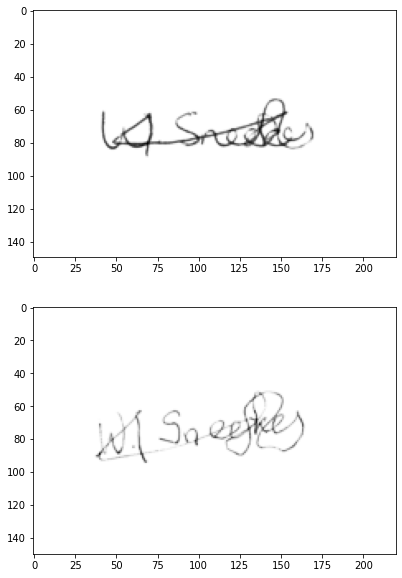

In [6]:
# Shows pre-processed samples of the two users

f, ax = plt.subplots(2,1, figsize=(15,10))
ax[0].imshow(preprocessed_img1)
ax[1].imshow(preprocessed_img2)

# Dataset Loader

In [7]:
class SignatureDataset(Dataset):
    
    def __init__(self, df, canvas_size, dim=(256, 256)):
        self.df  = df
        self.real_file_names = df["image_real_paths"].values
        self.forged_file_names = df["image_forged_paths"].values
        self.labels = df["label"].values
        self.dim = dim
        self.canvas_size=canvas_size

    def __len__(self):
        return len(self.df)
        
    def __getitem__(self,index):
        # getting the image path
        real_file_path = self.real_file_names[index]
        forged_file_path = self.forged_file_names[index]
        
        img1 = load_signature(real_file_path)
        img2 = load_signature(forged_file_path)
        
        img1 = preprocess_signature(img1, canvas_size, self.dim)
        img2 = preprocess_signature(img2, canvas_size, self.dim)
        
        label = torch.tensor(self.labels[index], dtype=torch.long)
        
        return torch.tensor(img1), torch.tensor(img2), label.float()

# Get Predictions on test set

In [8]:
def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch()

In [9]:
class CFG:
    apex=False
    debug=False
    print_freq=100
    size=128
    num_workers=2
    scheduler='CosineAnnealingLR' # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts','OneCycleLR']
    epochs=15
    # CosineAnnealingLR params
    cosanneal_params={
        'T_max':4,
        'eta_min':1e-5,
        'last_epoch':-1
    }
    #ReduceLROnPlateau params
    reduce_params={
        'mode':'min',
        'factor':0.2,
        'patience':4,
        'eps':1e-6,
        'verbose':True
    }
    # CosineAnnealingWarmRestarts params
    cosanneal_res_params={
        'T_0':3,
        'eta_min':1e-6,
        'T_mult':1,
        'last_epoch':-1
    }
    onecycle_params={
        'pct_start':0.1,
        'div_factor':1e2,
        'max_lr':1e-3,
        'steps_per_epoch':7, 
        'epochs':7
    }
    batch_size=16
    lr=1e-3
    weight_decay=1e-3
    canvas_size = (952, 1360)
    gradient_accumulation_steps=1
    max_grad_norm=1000
    nfolds=5
    trn_folds=[0]
    model_name='convnet'     #'vit_base_patch32_224_in21k' 'tf_efficientnetv2_b0' 'resnext50_32x4d' 'tresnet_m'
    train=True
    early_stop=True
    target_col="label"
    projection2d=False
    fc_dim=512
    early_stopping_steps=5
    grad_cam=False
    seed=42
    


In [10]:
class SigNet(nn.Module):
    """ SigNet model, from https://arxiv.org/abs/1705.05787
    """
    def __init__(self):
        super(SigNet, self).__init__()

        self.feature_space_size = 2048

        self.conv_layers = nn.Sequential(OrderedDict([
            ('conv1', conv_bn_mish(1, 96, 11, stride=4)),
            ('maxpool1', nn.MaxPool2d(3, 2)),
            ('conv2', conv_bn_mish(96, 256, 5, pad=2)),
            ('maxpool2', nn.MaxPool2d(3, 2)),
            ('conv3', conv_bn_mish(256, 384, 3, pad=1)),
            ('conv4', conv_bn_mish(384, 384, 3, pad=1)),
            ('conv5', conv_bn_mish(384, 256, 3, pad=1)),
            ('maxpool3', nn.MaxPool2d(3, 2)),
        ]))

        self.fc_layers = nn.Sequential(OrderedDict([
            ('fc1', linear_bn_mish(256 * 3 * 5, 2048)),
            ('fc2', linear_bn_mish(self.feature_space_size, self.feature_space_size)),
        ]))
    
    def forward_once(self, img):
        x = self.conv_layers(img)
        x = x.view(x.shape[0], 256 * 3 * 5)
        x = self.fc_layers(x)
        return x
        
    def forward(self, img1, img2):
        
        # Inputs need to have 4 dimensions (batch x channels x height x width), and also be between [0, 1]
        img1 = img1.view(-1, 1, 150, 220).float().div(255)
        img2 = img2.view(-1, 1, 150, 220).float().div(255)
        # forward pass of input 1
        output1 = self.forward_once(img1)
        # forward pass of input 2
        output2 = self.forward_once(img2)
        return output1, output2


def conv_bn_mish(in_channels, out_channels, kernel_size,  stride=1, pad=0):
    return nn.Sequential(OrderedDict([
        ('conv', nn.Conv2d(in_channels, out_channels, kernel_size, stride, pad, bias=False)),
        ('bn', nn.BatchNorm2d(out_channels)),
        ('relu', nn.Mish()),
    ]))


def linear_bn_mish(in_features, out_features):
    return nn.Sequential(OrderedDict([
        ('fc', nn.Linear(in_features, out_features, bias=False)),  # Bias is added after BN
        ('bn', nn.BatchNorm1d(out_features)),
        ('relu', nn.Mish()),
    ]))

class SiameseModel(nn.Module):
  
    """ SigNet model, from https://arxiv.org/abs/1705.05787
    """
    def __init__(self):
        super(SiameseModel, self).__init__()

        self.model = SigNet()
        state_dict, _, _ = torch.load("/content/drive/MyDrive/Image_forensics/signet.pth")
        self.model.load_state_dict(state_dict)
        
        if CFG.projection2d:
            self.probs = nn.Linear(4, 1)
        else:
            self.probs = nn.Linear(self.model.feature_space_size*2, 1)
        self.projection2d = nn.Linear(self.model.feature_space_size, 2)
    
    def forward_once(self, img):
        x = self.model.forward_once(img)
        return x
        
    def forward(self, img1, img2):
        
        # Inputs need to have 4 dimensions (batch x channels x height x width), and also be between [0, 1]
        # forward pass of input 1
        img1 = img1.view(-1, 1, 150, 220).float().div(255)
        img2 = img2.view(-1, 1, 150, 220).float().div(255)
        embedding1 = self.forward_once(img1)
        # forward pass of input 2
        embedding2 = self.forward_once(img2)
        
        if CFG.projection2d:
            print("Project embeddings into 2d space")
            embedding1 = self.projection2d(embedding1)
            embedding2 = self.projection2d(embedding2)
            # Classification
            output = torch.cat([embedding1, embedding2], dim=1)
            output= self.probs(output)
            return embedding1, embedding2, output
        else:
            # Classification
            output = torch.cat([embedding1, embedding2], dim=1)
            output= self.probs(output)
            return embedding1, embedding2, output


def conv_bn_mish(in_channels, out_channels, kernel_size,  stride=1, pad=0):
    return nn.Sequential(OrderedDict([
        ('conv', nn.Conv2d(in_channels, out_channels, kernel_size, stride, pad, bias=False)),
        ('bn', nn.BatchNorm2d(out_channels)),
        ('relu', nn.Mish()),
    ]))


def linear_bn_mish(in_features, out_features):
    return nn.Sequential(OrderedDict([
        ('fc', nn.Linear(in_features, out_features, bias=False)),  # Bias is added after BN
        ('bn', nn.BatchNorm1d(out_features)),
        ('relu', nn.Mish()),
    ]))

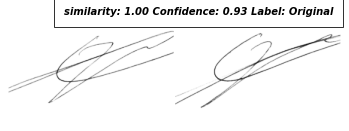

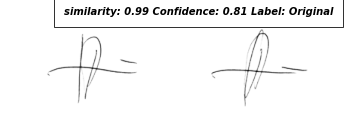

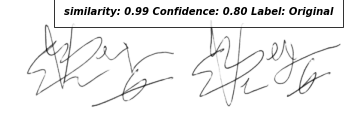

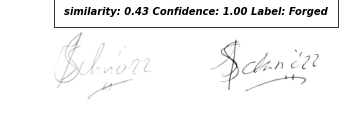

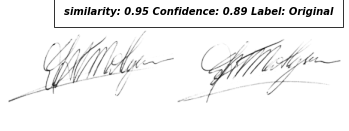

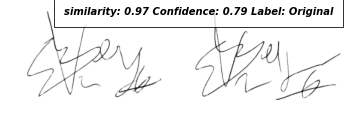

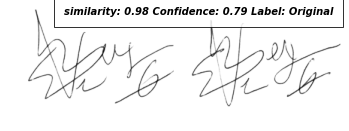

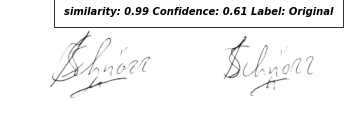

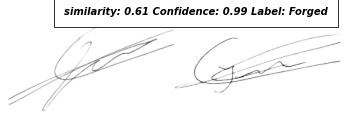

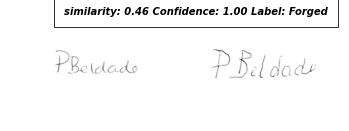

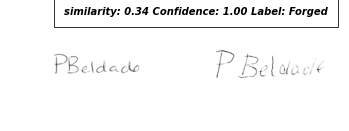

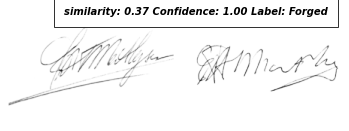

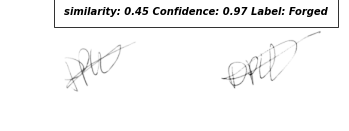

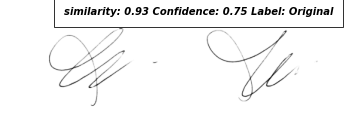

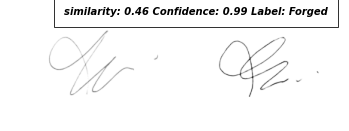

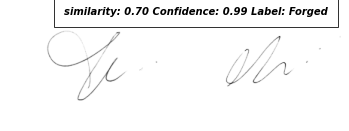

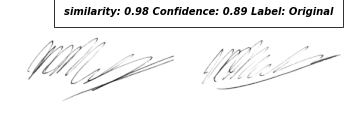

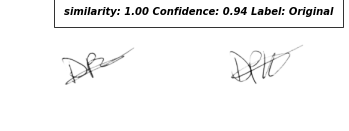

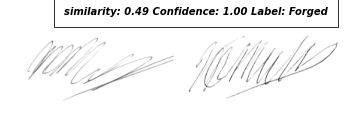

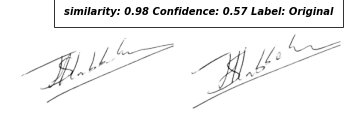

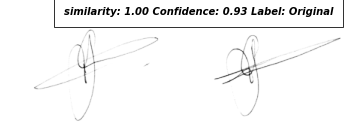

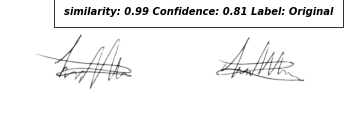

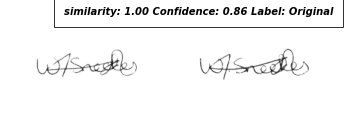

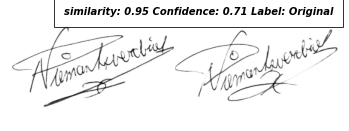

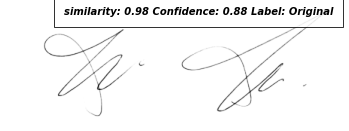

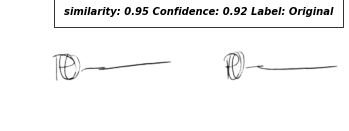

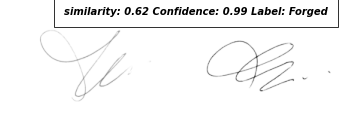

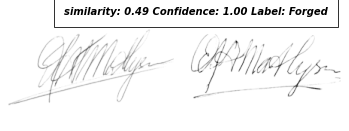

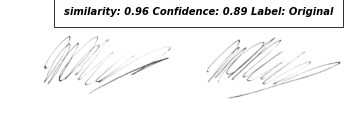

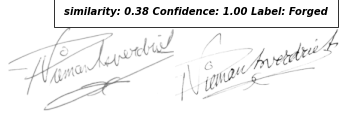

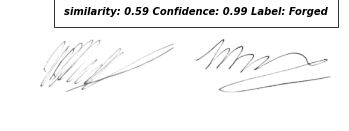

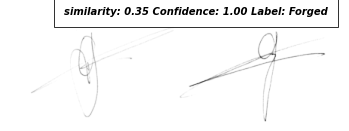

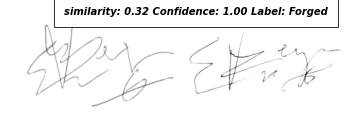

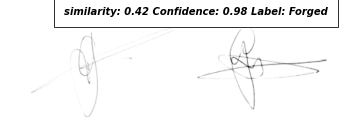

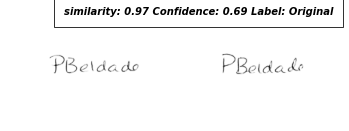

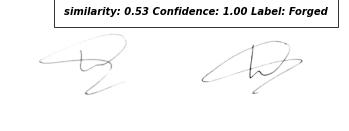

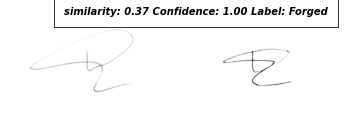

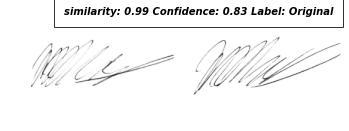

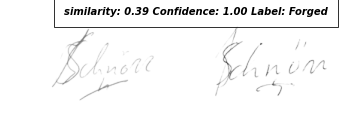

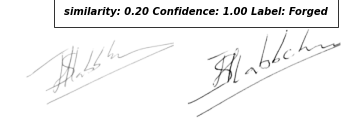

<Figure size 432x288 with 0 Axes>

In [11]:
model = SiameseModel()
model.load_state_dict(torch.load('/content/drive/MyDrive/Image_forensics/final_project_image_forensics/Siamese signature verification with confidence/convnet_best_loss.pt')['model'])


test_dataset = SignatureDataset(test, CFG.canvas_size, dim=(256, 256))

test_loader = DataLoader(test_dataset,
                              batch_size=1, 
                              shuffle=True, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)

counter = 0 
label_dict = {1.0:'Forged', 0.0:'Original'}
CFG.projection2d=False
model.eval()
for i, data in enumerate(test_loader, 0):
    img1, img2, label = data
    concatenated = torch.cat((img1, img2),0)
    with torch.no_grad():
        op1, op2, confidence = model(img1.to('cpu'), img2.to('cpu'))
    confidence = confidence.sigmoid().detach().to('cpu')
    if label == 0.0:
        confidence = 1 - confidence
    cos_sim = F.cosine_similarity(op1, op2)

    imshow(torchvision.utils.make_grid(concatenated.unsqueeze(1)), f'similarity: {cos_sim.item():.2f} Confidence: {confidence.item():.2f} Label: {label_dict[label.item()]}')
    plt.savefig('siamese.png')
    counter+=1
    if counter==40:
        break